## Housing: XGB, score: 0.12090

This dataset contains an abundance of missing values. It is not enough, however, to simple choose an imputation technique and proceed. Missing values need to be explored in order to determine the best handling method. For example, many of the null values are related (i.e. no basement = no finished, basement base, etc). Additionally, it cannot be assumed that a feature with a high percentage of null values should be removed. The pool feature is an example of this as it's null values exceed 99.6%. However, since null values indicate the absence of a pool, thee presence of a pool can carry additional price information that should be included in the model.  

__Approach:__

1. Missing values 
2. Engineer features
3. Pipelines
4. Stack models

In [1]:
# VIEW IMPORTS IN ATTACHED FILE
from housing_imports import *

Using TensorFlow backend.
/Users/jacob/anaconda3/envs/housing/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
# PRESERVE THE HOME IDS IN FROM THE TEST SET. MERGE THE TWO SETS FOR PROCESSING
csv_train = pd.read_csv('../data/train(1).csv').drop_duplicates()
csv_test = pd.read_csv('../data/test(1).csv').drop_duplicates()
y = csv_train.iloc[:, -1]
data = pd.concat([csv_train.iloc[:, 1:-1], csv_test.iloc[:, 1:]], axis=0)
data.reset_index(drop=True, inplace=True)
# print(data.shape)
house_id = pd.DataFrame(csv_test.Id)

### EDA -> MISSING VALUES AND TARGET FEATURE

In [3]:
# COUPLE DIFFERENT TYPES OF NULL VALUES
null_columns=data.columns[data.isnull().any()]
data[null_columns].isnull().sum().head() # ABBREVIATED

MSZoning          4
LotFrontage     486
Alley          2721
Utilities         2
Exterior1st       1
dtype: int64

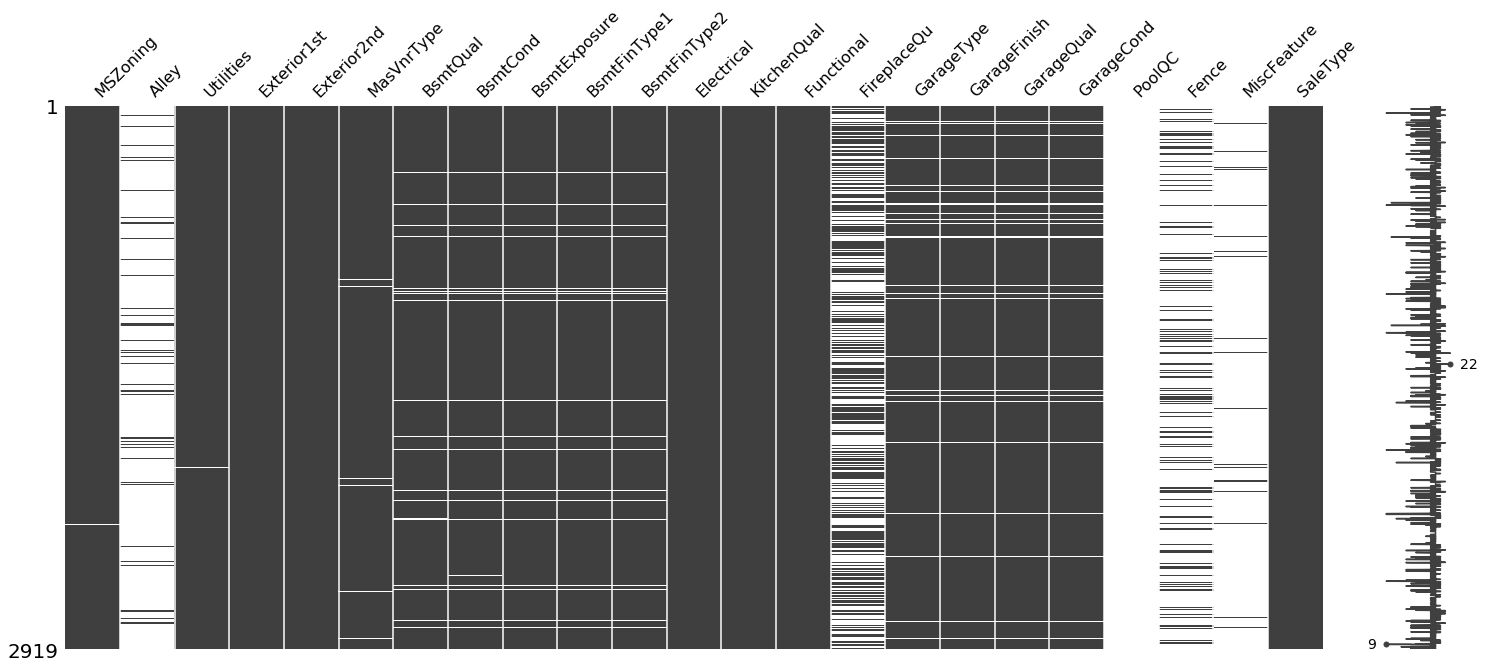

In [4]:
# NULL VALUES FOR GARAGE AND BASEMENT FOLLOW A TREND
import missingno as msno
cats = TypeSelector(np.object).fit_transform(data)
nulls = cats[cats.columns[cats.isnull().any()]]
msno.matrix(nulls);

In [5]:
# CREATE ABSOLUTE TIME FEATURES -> EASY ANSWER. TACKING ON A STRING ENSURES
# THAT THE NUMBER IS NOT ACCIDENTLY CONVERTED BACK TO A NUMERICAL LATER
# ALSO KEEP NUMERICALS FOR BINNING
# GarageYrBlt REMOVED

years = ['YearBuilt', 'YearRemodAdd', 'YrSold']

for colname in years:
        data[colname + '_cat'] = data[colname].apply(lambda x: x if np.isnan(x) else 'year_' + str(int(x)))

# PERMANENTLY TRANSFORM TO CAT - NOT NUMERICAL IN NATURE
data['MSSubClass'] = data.MSSubClass.apply(lambda x: 'class ' + str(x)) 


In [6]:
# NOT MUCH DIFFERENCE BETWEEN GarageYrBlt AND YearBuilt. BASICALLY, 
# THE VALUES DIFFER IF A GARAGE WAS ADDED. A NEW INDICATER FEATURE IS 
# MADE AND THE COLUMN IS DROPPEED

for i in tqdm(range(0, data.shape[0])):
    if np.isnan(data.GarageYrBlt[i]):
        year = data.YearBuilt[i]
        data.GarageYrBlt[i] = year
        
data.GarageYrBlt = data.GarageYrBlt.apply(lambda x: int(x))

new_feat = []
for i in range(0, data.shape[0]):
    if data.GarageYrBlt[i] == data.YearBuilt[i]:
        new_feat.append(0)
    else:
        new_feat.append(1)

# CREATE AN INDICATOR DATAFRAME. THIS HELPS AVOID CONFUSION DURING FINAL
# PREPROCESSING

    
data['Garage_added'] = new_feat
data['Garage_added'] = data['Garage_added'].astype("bool")
data.drop(['GarageYrBlt'], axis=1, inplace=True)

100%|██████████| 2919/2919 [00:10<00:00, 274.43it/s]


In [7]:
# CREATE AN INDICTATOR FOR REMODEL
new_feat = []
for i in range(0, data.shape[0]):
    if data.YearBuilt[i] == data.YearRemodAdd[i]:
        new_feat.append(0)
    else:
        new_feat.append(1)
        
data['Remodeled'] = new_feat
data['Remodeled'] = data['Remodeled'].astype("bool")
# CONVERT A FEW MORE BOOLS FOR FUN
data['paved_street'] = data.Street.apply(lambda x: 1 if x == 'Pave' else 0).astype('bool')
data['central_air'] = data.CentralAir.apply(lambda x: 1 if x == 'Y' else 0).astype('bool')
data.drop(['Street', 'CentralAir'], axis=1, inplace=True)
# WE'LL LEAVE YearRemodAdd FOR FEATURE SELECTION 

In [8]:
# ADDING RELATIVE REFACTORED TIME FEATURES
import datetime
current = datetime.date.today()
# print(current.year)
data['sold_delta'] = current.year - data['YrSold'] 
data['built_delta'] = current.year - data['YearBuilt'] 
data['remodel_delta'] = current.year - data['YearRemodAdd'] 

In [9]:
# GIVEN THE NUMBER OF NULLS, DISTRIBUTION OF VALUES, AND RELATIONSHIP
# BETWEEN FEATURES, SOME NULLS WILL BE FILLED WITH MODE AND SOME WILL
# BE CONVERTED TO A NEW CATEGORY, "NONE"

none_list = ['Alley', 
       'MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinType2', 
       'FireplaceQu', 'GarageType', 'GarageFinish',
       'GarageQual', 'GarageCond', 'Fence', 'MiscFeature', 'PoolQC']

for colname in none_list:
    data[colname].fillna('None', inplace=True)
    

In [10]:
# LOOKS READY FOR THE PIPELINES
null_columns=data.columns[data.isnull().any()]
print(data[null_columns].isnull().sum())


MSZoning          4
LotFrontage     486
Utilities         2
Exterior1st       1
Exterior2nd       1
MasVnrArea       23
BsmtFinSF1        1
BsmtFinSF2        1
BsmtUnfSF         1
TotalBsmtSF       1
Electrical        1
BsmtFullBath      2
BsmtHalfBath      2
KitchenQual       1
Functional        2
GarageCars        1
GarageArea        1
SaleType          1
dtype: int64


### Preprocessing Pipeline

The remain preprocessing has been abstracted using sklearn pipelines and a mix of transformers. Some of the transformers are lesser known (i.e. SoftImpute), some are wrapped standard transformers (i.e. KBins, StandardScaler), and some are custom (i.e. RegImpute, FreqFeatures). All of the wrapped classes can be viewed in attachments. The main purpose for the wrappers was to allow for pipeline use. 

In [11]:
# I'VE ABSTRACTED AWAY MOST OF THE PREPROCESSING AND BASIC ENGINEERING. THE
# TRANSFORMERS ARE VIEWABLE IN ATTACHMENTS. SOME OF THE TRANSFORMERS ARE SIMPLY
# WRAPPERS THAT ALLOW THE TRANSFORMERS TO FUNCTION IN AN SKLEARN PIPELINE.

transformer_list=[
        ("binned_features", make_pipeline(
                        TypeSelector(np.number),
                        StandardScalerDf(),
                        SoftImputeDf(),
                        SelectFeatures(),
                        KBins()
        )),
        ("numeric_features", make_pipeline(
                            TypeSelector(np.number),
                            StandardScalerDf(),
                            SoftImputeDf()
        )),
        ("categorical_features", make_pipeline(
                             TypeSelector(np.object),
                             RegImpute() 
        )),
        ("frequency_features", make_pipeline(
                         TypeSelector(np.object),
                         RegImpute(),
                         SelectFeatures(val_count=15, categorical=True),
                         FreqFeatures()
        )),
        ("boolean_features", make_pipeline(
                         TypeSelector(np.bool_),
                         RegImpute(regex=False) 
        ))  ]

__PandasFeatureUnion__ simply corrects for the numpy array output of sklearn FeatureUnion. It can be downloaded from Github at: https://github.com/marrrcin/pandas-feature-union

__QuickPipeline__ is an awesome preprocessing pipeline that can be found at: https://github.com/Mottl/quickpipeline.

It is slightly modified below to work in an sklearn pipeline. Basically, it inherits TransformerMixin and is given fit & transform functions rather than only fit_transform.

In [12]:
preprocess_pipeline = make_pipeline(
    PandasFeatureUnion(transformer_list),
    QuickPipeline_mod()  )
    

In [13]:
X = preprocess_pipeline.fit_transform(data)

In [14]:
# I TRY TO KEEP THINGS IN PANDAS MOST OF THE TIME. THIS COMES IN HANDY WHEN 
# ANALYZING FEATURES LATER ON. 
X.head(2)

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,sold_delta,built_delta,remodel_delta,Utilities,MSSubClass_freq,Neighborhood_freq,Exterior2nd_freq,YearBuilt_cat_freq,YearRemodAdd_cat_freq,Garage_added,Remodeled,paved_street,central_air,LotFrontage_bin_category_0.0,LotFrontage_bin_category_1.0,LotFrontage_bin_category_2.0,LotFrontage_bin_category_3.0,LotFrontage_bin_category_4.0,LotArea_bin_category_0.0,LotArea_bin_category_1.0,LotArea_bin_category_2.0,LotArea_bin_category_3.0,LotArea_bin_category_4.0,YearBuilt_bin_category_0.0,YearBuilt_bin_category_1.0,YearBuilt_bin_category_2.0,YearBuilt_bin_category_3.0,YearBuilt_bin_category_4.0,YearRemodAdd_bin_category_0.0,YearRemodAdd_bin_category_1.0,YearRemodAdd_bin_category_2.0,YearRemodAdd_bin_category_3.0,YearRemodAdd_bin_category_4.0,MasVnrArea_bin_category_2.0,MasVnrArea_bin_category_3.0,MasVnrArea_bin_category_4.0,BsmtFinSF1_bin_category_1.0,BsmtFinSF1_bin_category_2.0,BsmtFinSF1_bin_category_3.0,BsmtFinSF1_bin_category_4.0,BsmtUnfSF_bin_category_0.0,BsmtUnfSF_bin_category_1.0,BsmtUnfSF_bin_category_2.0,BsmtUnfSF_bin_category_3.0,BsmtUnfSF_bin_category_4.0,TotalBsmtSF_bin_category_0.0,TotalBsmtSF_bin_category_1.0,TotalBsmtSF_bin_category_2.0,TotalBsmtSF_bin_category_3.0,TotalBsmtSF_bin_category_4.0,1stFlrSF_bin_category_0.0,1stFlrSF_bin_category_1.0,1stFlrSF_bin_category_2.0,1stFlrSF_bin_category_3.0,1stFlrSF_bin_category_4.0,2ndFlrSF_bin_category_2.0,2ndFlrSF_bin_category_3.0,2ndFlrSF_bin_category_4.0,GrLivArea_bin_category_0.0,GrLivArea_bin_category_1.0,GrLivArea_bin_category_2.0,GrLivArea_bin_category_3.0,GrLivArea_bin_category_4.0,GarageArea_bin_category_0.0,GarageArea_bin_category_1.0,GarageArea_bin_category_2.0,GarageArea_bin_category_3.0,GarageArea_bin_category_4.0,WoodDeckSF_bin_category_2.0,WoodDeckSF_bin_category_3.0,WoodDeckSF_bin_category_4.0,OpenPorchSF_bin_category_2.0,OpenPorchSF_bin_category_3.0,OpenPorchSF_bin_category_4.0,built_delta_bin_category_0.0,built_delta_bin_category_1.0,built_delta_bin_category_2.0,built_delta_bin_category_3.0,built_delta_bin_category_4.0,remodel_delta_bin_category_0.0,remodel_delta_bin_category_1.0,remodel_delta_bin_category_2.0,remodel_delta_bin_category_3.0,remodel_delta_bin_category_4.0,MSSubClass_class120,MSSubClass_class150,MSSubClass_class160,MSSubClass_class180,MSSubClass_class190,MSSubClass_class20,MSSubClass_class30,MSSubClass_class40,MSSubClass_class45,MSSubClass_class50,MSSubClass_class60,MSSubClass_class70,MSSubClass_class75,MSSubClass_class80,MSSubClass_class85,MSSubClass_class90,MSZoning_Call,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Alley_Grvl,Alley_None,Alley_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType

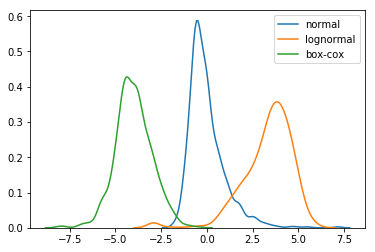

In [15]:
# TAKING THE LOG OF THE TARGET CORRECTS FOR A RIGHT SKEW. HOWEVER, THE LOGNORMAL
# CREATES A SLIGHT LEFT SKEW
# NORMALIZATION IS FOR COMPARISON PURPOSES ONLY
# SEPARATED FOR COMPARISON ONLY

y_norm = y.apply(lambda x: (x - y.mean()) / y.std())
y_box, lambda_ = boxcox(y) # need the lambda to eventually reverse the transformation
y_box_norm = pd.DataFrame(y_box).apply(lambda x: (x - y_box.mean()) / y_box.std())
sns.kdeplot(y_norm, label='normal')
sns.kdeplot(np.log(y_norm) + 4, label='lognormal')
sns.kdeplot(np.ravel(y_box_norm) - 4, label='box-cox')
plt.legend();

# THE LEAST SKEWED IS THE BOX COX TRANSFORMATION
y, lambda_ = boxcox(y)


In [16]:
# MAKE SURE THE BOX COX IS REVERSIBLE. THE POWER TRANSFORM AVAILABLE 
# THROUGH SKLEARN DOES NOT SEEM TO PROVIDE A LAMBDA AND IS NOT EASILY REVERSIBLE

def invboxcox(y,ld):
    if ld == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(ld*y+1)/ld))

#  LITTLE TEST TO MAKE SURE
# test = csv_train.iloc[:, -1][:100]; print(test[:3])
# y_box_test, lambda_test = boxcox(test); print(pd.Series(y_box_test)[:3])
# # Add 1 to be able to transform 0 values
# test_rev = invboxcox(y_box_test, lambda_test);print(pd.Series(test_rev).apply(lambda x: np.int64(x))[:3])


In [17]:
X_test = X.iloc[1460:, :]
X_ = X.iloc[:1460, :]
print(X_.shape);print(X_test.shape);print(y.shape)
X_train = X_
y_train = y

(1460, 578)
(1459, 578)
(1460,)


### Stacked Models

You'll notice the __Bayes__ wrapper around each model. If you look at models.py, you'll see that a bayes optimizer is embedded in each model. Intervals are defined using dictionaries. 

In [18]:
xgb_params

{'learning_rate': (0.03, 0.1),
 'min_child_weight': (1, 4),
 'max_depth': (3, 4),
 'subsample': (0.8, 1.0),
 'colsample_bytree': (0.8, 1.0),
 'reg_lambda': (1e-09, 1.5),
 'reg_alpha': (1e-09, 1.0),
 'gamma': (1e-09, 0.1),
 'n_estimators': (150, 500)}

While bayesian hyperparameter optimization is an exciting field, it is a bit harder to implement than one may initially assume. Simply defining large intervals for the optimizer to use will generally result in poorer performance. I explored this in detail in my master's thesis. Basically, one can spend a lifetime trying to understand a given hyperparameter's affect on model behavior, only to see the model completely misbehave or respond differently given another hyperparameter's interval. The best method I've found, is to obtain a decent understanding of the given hyperparameter and default setting. Using a smaller random subset of data, begin testing different intervals using cross validation scores. I'll also search online for hyperparameters used for similarly sized data and test intervals based off values used by other data scientists. 

I'm also exploring combining a grid search method (for intervals) with bayesian techniques.

In [19]:
# REGRESSORS
lgb = BayesLGBMRegressor()
# LGBM WOULD NOT ACCEPT A DICT AS A HYPERPARAMETER - I'D NEED TO EXPLORE THIS MORE, USE **kwargs
svr = BayesSVR(intervals=svr_params)
rf = BayesRandomForest(intervals=rf_params)
regressors = [lgb, svr, rf]

# META-REGRESSOR
meta = BayesXGBRegressor(intervals=xgb_params)

In [20]:
# RELATIVELY STRAIGHTFORWARD. EASY TO DISSECT AND UNDERSTAND THE RELATIONSHIP
# BETWEEN THE META-MODEL AND BASE MODELS.

ensemble = StackingCVRegressorAveraged(regressors=regressors, 
                                       meta_regressor=meta)

In [21]:
ensemble.fit(X_train, y_train)

StackingCVRegressorAveraged(meta_regressor=BayesXGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
         gamma=0,
         intervals={'learning_rate': (0.03, 0.1), 'min_child_weight': (1, 4), 'max_depth': (3, 4), 'subsample': (0.8, 1.0), 'colsample_bytree': (0.8, 1.0), 'reg_lambda': (1e-09, 1.5), 'reg_alp...s=-1,
         random_state=81, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
         subsample=1),
              n_folds=5,
              regressors=[BayesLGBMRegressor(class_weight=None, colsample_bytree=1.0, intervals=None,
          learning_rate=0.1, max_depth=-1, min_child_samples=20,
          min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
          n_jobs=-1, num_leaves=31, objective=None, random_state=81,
      ...    min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
         random_state=81, verbose=0)])

In [22]:
y_pred = ensemble.predict(X_test)

In [23]:
# REVERSE BOX COX TRANSFORMATION
labels = pd.DataFrame(invboxcox(y_pred, lambda_)).apply(lambda x: np.float64(round(x, 2)))

In [24]:
submit = pd.concat([house_id, labels], axis=1)

submit.set_index('Id', inplace=True)

submit.rename(columns={0: 'SalePrice'}, inplace=True)
submit.head()

,SalePrice
Id,
1461,126264.01
1462,157548.70
1463,175285.79
1464,189954.14
1465,187109.32


In [ ]:
# submit.to_csv('preds/predictions5.csv', index=True)

### Extra

__Notes__: While looking over the data description, it seemed like a lot of the categorical features could be converted to ordinal for additional 
features. I've included the transformations below. The ensemble performance unfortunately did not improve. However, that could easily be the result of the optimier intervals or ensemble method. 

In [ ]:
# SOME OF THE CATEGORICALS CAN ALSO BE REPRESENTED AS ORDINALS
# data['BsmtQual'].value_counts(dropna=False)
# cat_to_ordinal_1 = {'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 
#                     'Ex': 5}

# cat_to_ordinal_2 = {'None': 0, 'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 
#                     'ALQ': 5, 'GLQ': 6}

# Functionality = {'Sal Salvage': 0, 'Sev Severely': 1, 'Maj2': 2, 'Maj1': 3,
#                 'Mod': 4, 'Min2': 5, 'Min1': 6, 'Typ': 7}

# exposure = {'None': 0, 'No': 1, 'Mn': 2, 'Av': 3, 'Gd': 4}


In [ ]:
# cat_to_num_1 = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC',
#                'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond',
#                'PoolQC']

# cat_to_num_2 = ['BsmtFinType1', 'BsmtFinType2']


In [ ]:
# for feat in cat_to_num_1:
#     data[feat].fillna(data[feat].mode()[0], inplace=True)
#     data[feat + '_num'] = data[feat].map(cat_to_ordinal_1)

# for feat in cat_to_num_2:
#     data[feat].fillna(data[feat].mode()[0], inplace=True)
#     data[feat + '_num'] = data[feat].map(cat_to_ordinal_2)

# data['bsmt_exp_num'] =  data['BsmtExposure'].map(exposure)


__References:__

https://github.com/travisbrady/py-soft-impute

__other kagglers:__ 

https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard

https://www.kaggle.com/neviadomski/how-to-get-to-top-25-with-simple-model-sklearn